# 📊 Data Visualization Masterclass — Parte 2

Vedremo come Scegliere il grafico giusto, trasformare i dati e altre tecniche Avanzate

**Contesto:** Notebook didattico creato la classe avanzata di Data Analysis per Mondadori.
**Prerequisito:** Aver completato la Parte 1
**Dataset:** Stesso dataset editoriale della Parte 1

---

| Parte | Contenuto |
|-------|----------|
| **8** | La matrice decisionale: quale grafico per quale obiettivo |
| **9** | Trasformazione dei dati per la visualizzazione |
| **10** | Grafici avanzati: Slope, Bump, Dumbbell, Waterfall, Waffle |
| **11** | Dashboard design: comporre grafici in una vista coerente |
| **12** | Esercizio finale: brief → analisi → presentazione completa |

---
# Setup:
Ricreiamo il dataset dalla parte 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
sns.set_palette("husl")
np.random.seed(42)

GENERI = ['Narrativa','Thriller','Saggistica','Fantasy','Romance','Storico','Sci-Fi','Poesia','Bambini','Young Adult']
COLLANE = ['Oscar Mondadori','Strade Blu','Contemporanea','Chrysalide','Omnibus','Piccoli Brividi','Classici Moderni','Voci']
FORMATI = ['Cartaceo','Ebook','Audiolibro']
CANALI = ['Libreria fisica','Amazon','E-commerce proprio','GDO','Fiere/Eventi']
GW = {'Narrativa':.22,'Thriller':.18,'Saggistica':.15,'Fantasy':.10,'Romance':.09,'Storico':.08,'Sci-Fi':.06,'Poesia':.02,'Bambini':.05,'Young Adult':.05}
n_libri=500; n_mesi=24
libri = pd.DataFrame({'libro_id':range(1,n_libri+1),'titolo':[f"Titolo_{i:03d}" for i in range(1,n_libri+1)],
    'genere':np.random.choice(list(GW.keys()),n_libri,p=list(GW.values())),'collana':np.random.choice(COLLANE,n_libri),
    'anno_pubblicazione':np.random.choice(range(2018,2025),n_libri,p=[.05,.05,.08,.10,.15,.25,.32]),
    'pagine':np.random.normal(280,80,n_libri).astype(int).clip(80,800),
    'prezzo_copertina':np.round(np.random.uniform(9.90,24.90,n_libri),2),
    'rating_goodreads':np.round(np.random.normal(3.7,0.5,n_libri).clip(1.5,5.0),1),
    'n_recensioni':np.random.exponential(150,n_libri).astype(int).clip(5,5000)})
libri.loc[libri['genere']=='Thriller','prezzo_copertina'] *= 1.1
libri.loc[libri['genere']=='Narrativa','prezzo_copertina'] *= 1.05
libri.loc[libri['genere']=='Poesia','prezzo_copertina'] *= 0.8
libri['prezzo_copertina'] = libri['prezzo_copertina'].round(2)
date_range = pd.date_range('2023-01-01',periods=n_mesi,freq='MS')
recs = []
for _,libro in libri.iterrows():
    base={'Narrativa':120,'Thriller':150,'Saggistica':80,'Fantasy':90,'Romance':70,'Storico':50,'Sci-Fi':45,'Poesia':15,'Bambini':60,'Young Adult':55}[libro['genere']]
    lm=np.random.lognormal(0,0.8)
    for i,data in enumerate(date_range):
        m=data.month;stag={12:1.8,11:1.3,6:1.2,7:1.2,1:0.7,2:0.7}.get(m,1.0)
        trend={'Thriller':1+i*0.015,'Fantasy':1+i*0.01,'Young Adult':1+i*0.012,'Poesia':1-i*0.008,'Saggistica':1-i*0.003}.get(libro['genere'],1.0)
        for fmt in FORMATI:
            fs={'Cartaceo':0.55,'Ebook':0.30,'Audiolibro':0.15}[fmt]
            if fmt=='Ebook':fs*=(1+i*0.005)
            if fmt=='Audiolibro':fs*=(1+i*0.02)
            copie=max(0,int(base*lm*stag*trend*fs*np.random.lognormal(0,0.3)))
            if copie>0:
                recs.append({'libro_id':libro['libro_id'],'data':data,'formato':fmt,'canale':np.random.choice(CANALI,p=[.30,.35,.15,.12,.08]),'copie_vendute':copie,'ricavo':round(copie*libro['prezzo_copertina']*{'Cartaceo':1,'Ebook':.65,'Audiolibro':.55}[fmt],2)})
vendite=pd.DataFrame(recs)
df=vendite.merge(libri,on='libro_id',how='left')
df['anno']=df['data'].dt.year;df['trimestre']=df['data'].dt.to_period('Q').astype(str)
print(f"Dataset: {len(df):,} record")

Dataset: 35,904 record


---
# Parte 8 — La Matrice Decisionale

Il grafico non si sceglie per estetica, si sceglie per obiettivo comunicativo.

Ogni volta che ti trovi davanti a un dataset, la prima domanda non è "che grafico faccio?" ma "cosa voglio che il lettore capisca?". La risposta ricade spesso in uno di questi cinque obiettivi: confronto (chi è più grande?), andamento (come cambia nel tempo?), distribuzione (come sono distribuiti i valori?), composizione (che peso ha ogni parte sul tutto?), relazione (due variabili si muovono insieme?).

Il secondo parametro è il numero di elementi: un confronto tra 3 generi chiama un bar chart verticale, un confronto tra 15 chiama uno orizzontale, tra 40 un lollipop. La scala cambia la leggibilità, non solo l'estetica.

## 8.1 I 5 obiettivi comunicativi

| # | Obiettivo | Domanda chiave | Grafici consigliati |
|---|-----------|---------------|-------------------|
| 1 | **Confronto** | Qual e piu grande? | Bar, Lollipop |
| 2 | **Andamento** | Come cambia nel tempo? | Line, Area, Slope |
| 3 | **Distribuzione** | Come sono sparsi? | Histo, Box, Violin |
| 4 | **Composizione** | Da cosa e fatto il totale? | Stacked bar, Treemap, Waffle |
| 5 | **Relazione** | X e Y sono collegati? | Scatter, Bubble, Heatmap |

## 8.2 Scenari editoriali

| Domanda del business | Obiettivo | Grafico |
|---------------------|-----------|--------|
| Quale genere vende di piu? | Confronto | Bar orizzontale |
| Vendite in salita o discesa? | Andamento | Line chart |
| Quanto pesa il digitale? | Composizione | Stacked bar 100% |
| Legame prezzo-vendite? | Relazione | Scatter plot |
| Prezzi uniformi tra generi? | Distribuzione | Box plot |
| Come cambia la quota generi? | Andamento+Composiz. | Stacked area |
| Chi ha guadagnato quota? | Confronto (delta) | **Slope chart** |
| Chi sorpassa chi? | Andamento+Ranking | **Bump chart** |

La funzione suggerisci_grafico(obiettivo, n) formalizza queste regole in codice: non per sostituire il giudizio, ma per rendere esplicito il ragionamento che di solito resta implicito. Usatela come checklist, non come oracolo.

In [ ]:
# ============================================================
# 8.3 - Funzione di suggerimento grafico
# ============================================================
def suggerisci_grafico(obiettivo, n=None):
    """Suggerisce il grafico migliore."""
    rules = {
        'confronto':[(1,5,'Bar verticale'),(6,15,'Bar orizzontale'),(16,50,'Lollipop'),(51,999,'Treemap')],
        'andamento':[(1,3,'Line chart'),(4,7,'Line+highlight'),(8,999,'Small multiples')],
        'distribuzione':[(1,1,'Istogramma+KDE'),(2,5,'Box/Violin'),(6,999,'Ridge plot')],
        'relazione':[(2,2,'Scatter'),(3,3,'Bubble'),(4,999,'Heatmap')]
    }
    print(f"\n{'='*40}\n  OBIETTIVO: {obiettivo.upper()}\n{'='*40}")
    if obiettivo=='composizione':
        print('  Statico -> Stacked bar 100%'); print('  Temporale -> Stacked area'); return
    if n and obiettivo in rules:
        for lo,hi,chart in rules[obiettivo]:
            if lo<=n<=hi: print(f'  Con {n} elementi -> {chart}'); return chart

suggerisci_grafico('confronto', 10)
suggerisci_grafico('andamento', 2)
suggerisci_grafico('distribuzione', 4)
suggerisci_grafico('composizione')
suggerisci_grafico('relazione', 2)


  OBIETTIVO: CONFRONTO
  Con 10 elementi -> Bar orizzontale

  OBIETTIVO: ANDAMENTO
  Con 2 elementi -> Line chart

  OBIETTIVO: DISTRIBUZIONE
  Con 4 elementi -> Box/Violin

  OBIETTIVO: COMPOSIZIONE
  Statico -> Stacked bar 100%
  Temporale -> Stacked area

  OBIETTIVO: RELAZIONE
  Con 2 elementi -> Scatter


'Scatter'

---
# Parte 9 — Trasformazione dei Dati

I dati grezzi spesso mentono per omissione: non perché siano sbagliati, ma perché la scala o la forma in cui li presenti nasconde ciò che c'è dietro.

Le trasformazioni non alterano i dati, ma ne rimuovono il rumore visivo che impedisce di vederli.

- **Log scale**: i ricavi per libro seguono una distribuzione di Pareto estrema: pochi bestseller, lunghissima coda di titoli a basse vendite. In scala lineare il 90% dei libri si schiaccia a sinistra e non si vede nulla. La scala logaritmica espande i valori bassi e rivela la struttura reale della distribuzione.
> **Regola pratica**: se la skewness è $>2$, considera la scala log o riporta la mediana invece della media.
- **Moving average**: i dati mensili di vendita sono rumorosi per definizione: stagionalità, promozioni, uscite puntuali. La media mobile separa il segnale dal rumore. A 3 mesi è reattiva ma ancora rumorosa; a 6 mesi rivela il trend strutturale. Usale insieme: l'area grigia mostra la volatilità reale, la linea rossa racconta dove sta andando il mercato.
- **Variazione % MoM vs YoY**: il cambio mese su mese amplifica la stagionalità e va bene per il monitoraggio operativo. Il cambio anno su anno la elimina per definizione ed è quello che interessa al management: stiamo crescendo rispetto allo stesso periodo dell'anno scorso? Regola semplice: YoY per i dirigenti, MoM per chi gestisce le operazioni settimana per settimana.
- **Binning**: trasformare una variabile continua (prezzo, ricavo) in categorie (fascia bassa/media/alta) permette di costruire segmenti azionabili. La scelta dei breakpoint non è neutrale: bin uguali per ampiezza funzionano su distribuzioni simmetriche; bin per quantile funzionano meglio su distribuzioni skewed come i ricavi editoriali.

**Regola d'oro**: trasforma sempre prima di visualizzare, non invece di visualizzare. La trasformazione è uno step del ragionamento analitico, non un trucco grafico.

| Trasformazione | Quando | Effetto |
|---------------|--------|--------|
| **Normalizzazione (%)** | Scale diverse | Confrontabili |
| **Log scale** | Skewed | Espande bassi |
| **Moving Average** | Rumore | Mostra trend |
| **Variazione %** | Cambiamento | Focus su delta |
| **Binning** | Continuo->categ. | Crea gruppi |

> 📌 Distribuzione di Pareto (legge 80/20)

> Una distribuzione si dice "paretiana" quando una piccola minoranza degli elementi produce la grande maggioranza del risultato.

In campo editoriale: tipicamente il 20% dei titoli genera l'80% dei ricavi. Non è una legge fisica, ma un pattern empirico sorprendentemente stabile in molti mercati — musica, app store, e-commerce.

La conseguenza visiva è una distribuzione fortemente asimmetrica a destra (skewed): tanti valori bassi addensati a sinistra, pochissimi valori altissimi che stirano la coda verso destra. Questo è il motivo per cui la media è un indicatore fuorviante in questi contesti — un singolo bestseller può spostarla enormemente — e la mediana o la scala logaritmica diventano strumenti essenziali.

## 9.1 Log scale

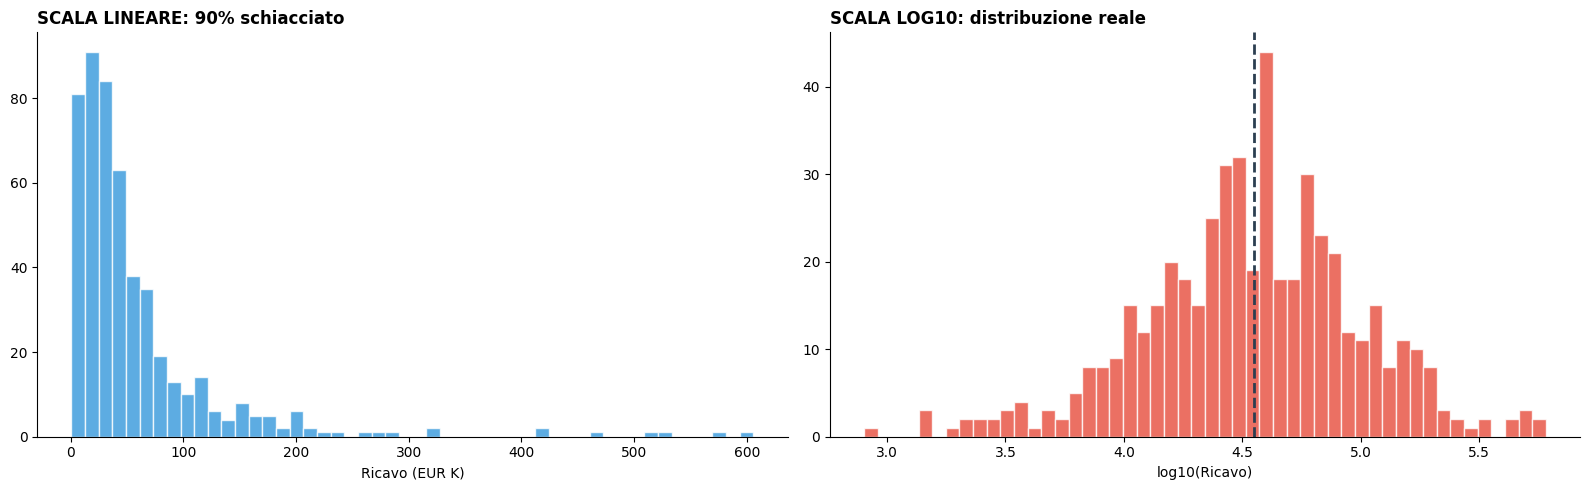

Skewness: 3.9 (>2 = molto asimmetrica -> usare log o mediana)


In [ ]:
# ============================================================
# 9.2 - LOG SCALE
# ============================================================
libro_ricavi = df.groupby('libro_id')['ricavo'].sum()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.hist(libro_ricavi.values/1000, bins=50, color='#3498db', edgecolor='white', alpha=0.8)
ax1.set_title('SCALA LINEARE: 90% schiacciato', fontsize=12, fontweight='bold', loc='left')
ax1.set_xlabel('Ricavo (EUR K)')
ax2.hist(np.log10(libro_ricavi.values.clip(1)), bins=50, color='#e74c3c', edgecolor='white', alpha=0.8)
ax2.set_title('SCALA LOG10: distribuzione reale', fontsize=12, fontweight='bold', loc='left')
ax2.set_xlabel('log10(Ricavo)')
ax2.axvline(np.log10(libro_ricavi.median()), color='#2c3e50', linestyle='--', linewidth=2)
for ax in [ax1,ax2]: ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.tight_layout(); plt.show()
print(f'Skewness: {libro_ricavi.skew():.1f} (>2 = molto asimmetrica -> usare log o mediana)')

## 9.2 Moving average

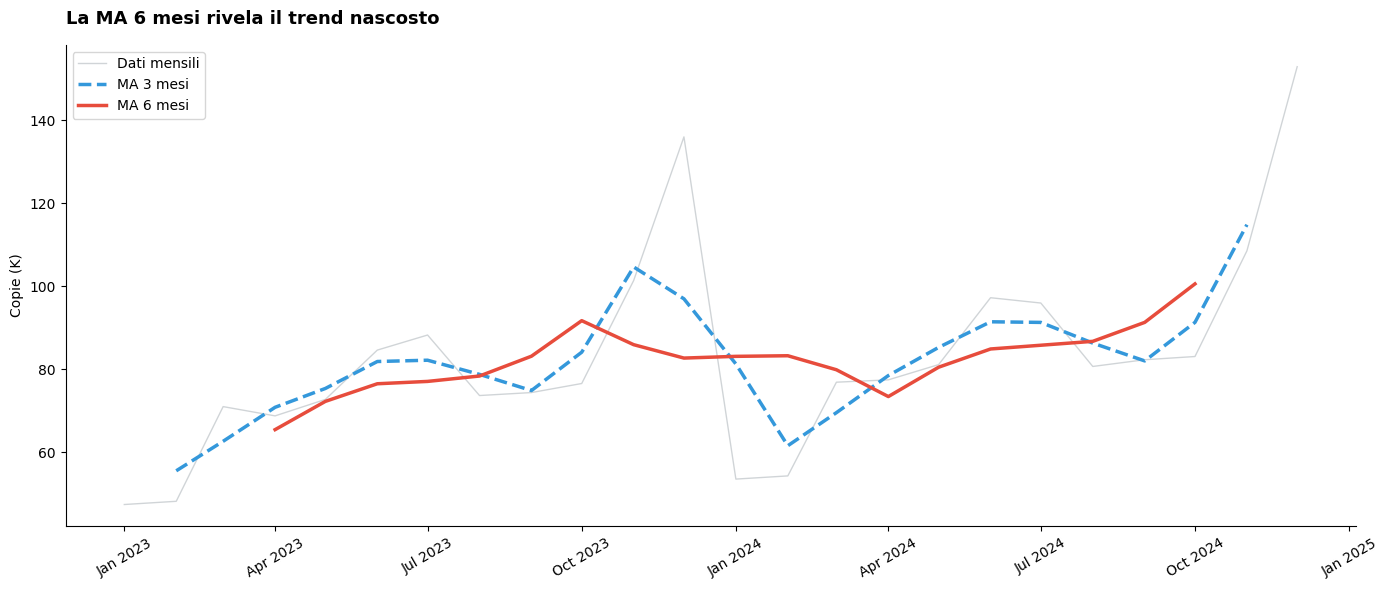

In [ ]:
# ============================================================
# 9.3 - MOVING AVERAGE
# ============================================================
vt = df.groupby('data')['copie_vendute'].sum()/1000
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(vt.index, vt.values, color='#bdc3c7', linewidth=1, alpha=0.7, label='Dati mensili')
for w,c,s in [(3,'#3498db','--'),(6,'#e74c3c','-')]:
    ma = vt.rolling(w,center=True).mean()
    ax.plot(ma.index, ma.values, color=c, linewidth=2.5, linestyle=s, label=f'MA {w} mesi')
ax.set_title('La MA 6 mesi rivela il trend nascosto', fontsize=13, fontweight='bold', loc='left', pad=15)
ax.set_ylabel('Copie (K)'); ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')); plt.xticks(rotation=30)
plt.tight_layout(); plt.show()

## 9.3 Variazione %: MoM vs YoY

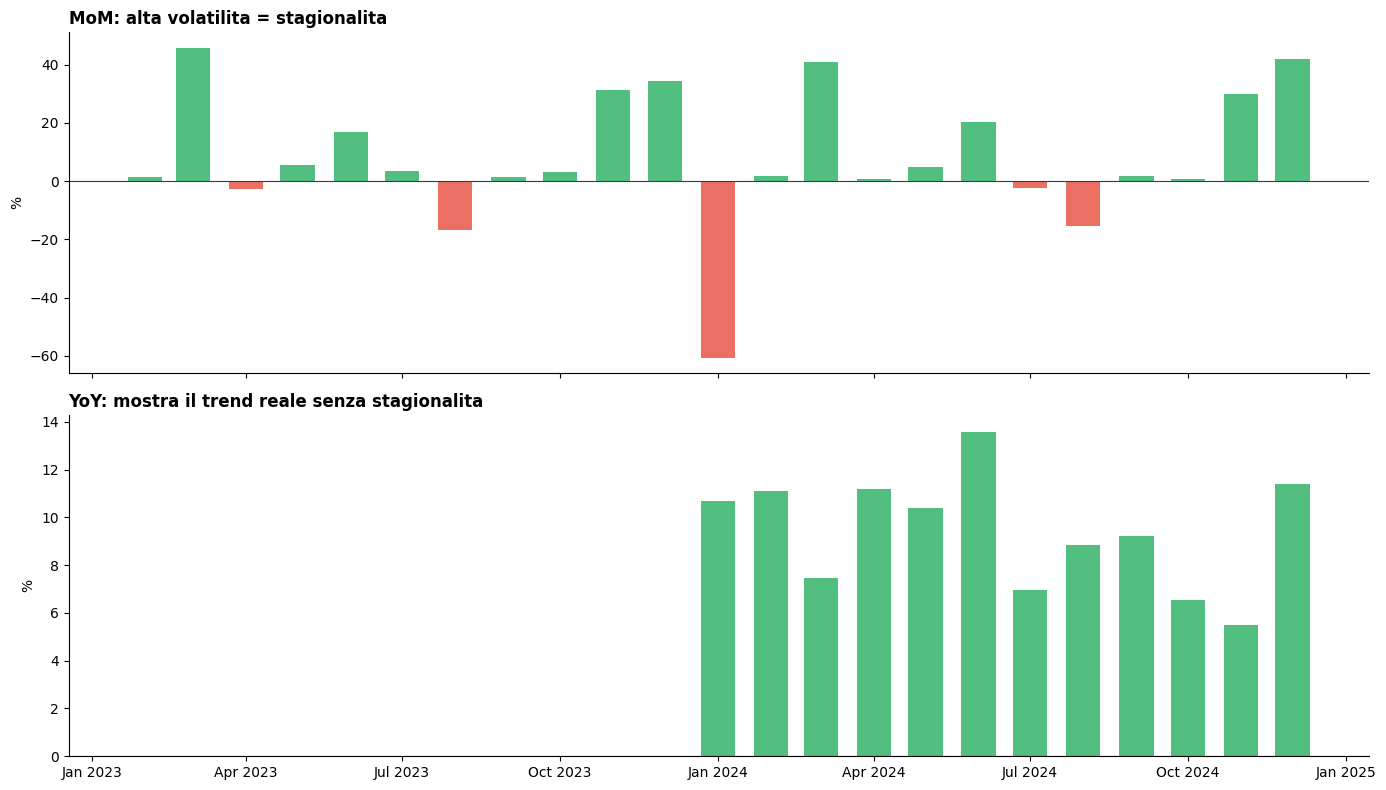

Regola: YoY per dirigenti, MoM per monitoraggio operativo.


In [ ]:
# ============================================================
# 9.4 - MoM vs YoY
# ============================================================
rm = df.groupby('data')['ricavo'].sum()
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8),sharex=True)
mom = rm.pct_change()*100
cm = ['#27ae60' if v>=0 else '#e74c3c' for v in mom.values[1:]]
ax1.bar(mom.index[1:],mom.values[1:],color=cm,width=20,alpha=0.8); ax1.axhline(0,color='#2c3e50',linewidth=0.8)
ax1.set_title('MoM: alta volatilita = stagionalita',fontsize=12,fontweight='bold',loc='left'); ax1.set_ylabel('%')
yoy_s = rm.pct_change(12)*100; vy = yoy_s.dropna()
cy = ['#27ae60' if v>=0 else '#e74c3c' for v in vy.values]
ax2.bar(vy.index,vy.values,color=cy,width=20,alpha=0.8); ax2.axhline(0,color='#2c3e50',linewidth=0.8)
ax2.set_title('YoY: mostra il trend reale senza stagionalita',fontsize=12,fontweight='bold',loc='left'); ax2.set_ylabel('%')
for ax in [ax1,ax2]: ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout(); plt.show()
print('Regola: YoY per dirigenti, MoM per monitoraggio operativo.')

## 9.4 Binning

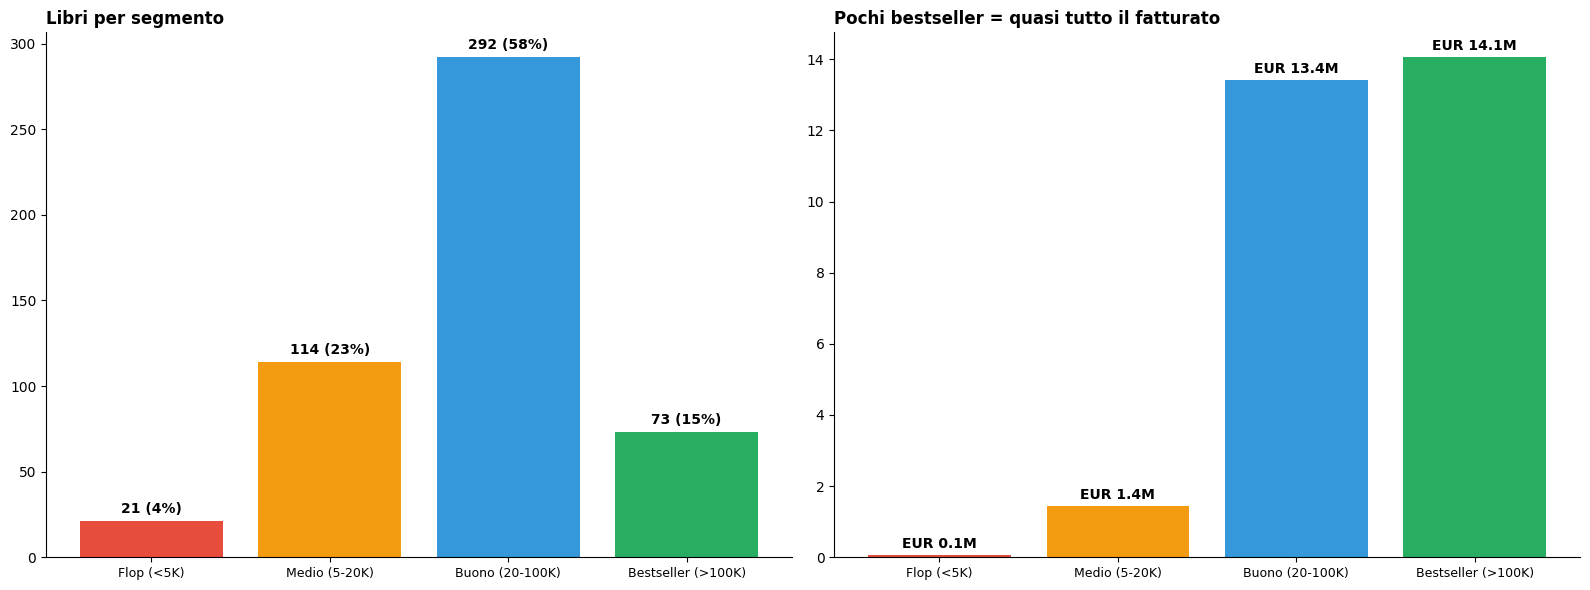

In [ ]:
# ============================================================
# 9.5 - BINNING
# ============================================================
lp = df.groupby('libro_id').agg(ricavo_tot=('ricavo','sum'),genere=('genere','first')).reset_index()
lp['seg'] = pd.cut(lp['ricavo_tot'],bins=[0,5000,20000,100000,float('inf')],labels=['Flop (<5K)','Medio (5-20K)','Buono (20-100K)','Bestseller (>100K)'])
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
sc=lp['seg'].value_counts().sort_index(); cs=['#e74c3c','#f39c12','#3498db','#27ae60']
bars=ax1.bar(range(len(sc)),sc.values,color=cs); ax1.set_xticks(range(len(sc))); ax1.set_xticklabels(sc.index,fontsize=9)
for b,v in zip(bars,sc.values): ax1.text(b.get_x()+b.get_width()/2,v+5,f'{v} ({v/len(lp)*100:.0f}%)',ha='center',fontsize=10,fontweight='bold')
ax1.set_title('Libri per segmento',fontsize=12,fontweight='bold',loc='left')
sr=lp.groupby('seg')['ricavo_tot'].sum().sort_index()/1e6
bars2=ax2.bar(range(len(sr)),sr.values,color=cs); ax2.set_xticks(range(len(sr))); ax2.set_xticklabels(sr.index,fontsize=9)
for b,v in zip(bars2,sr.values): ax2.text(b.get_x()+b.get_width()/2,v+0.2,f'EUR {v:.1f}M',ha='center',fontsize=10,fontweight='bold')
ax2.set_title('Pochi bestseller = quasi tutto il fatturato',fontsize=12,fontweight='bold',loc='left')
for ax in [ax1,ax2]: ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.tight_layout(); plt.show()

---
# Parte 10: Grafici avanzati
I grafici delle parti precedenti coprono il 90% dei casi. Questa parte copre quel 10% in cui hai bisogno di comunicare qualcosa di specifico che i grafici standard non sanno fare bene: variazioni tra due punti nel tempo, evoluzioni di ranking, decomposizioni di crescita, composizioni intuitive.

## 10.1 Slope Chart: il prima e dopo
Questo è il grafico giusto quando hai esattamente due momenti (2023 → 2024) e vuoi mostrare chi è salito e chi è sceso. Un line chart su due soli punti per categoria. La forza è nella semplicità: l'inclinazione della linea è immediatamente leggibile, e il colore (verde/rosso) aggiunge un layer di giudizio senza parole. Usalo al posto del grouped bar chart quando il movimento conta più del valore assoluto.

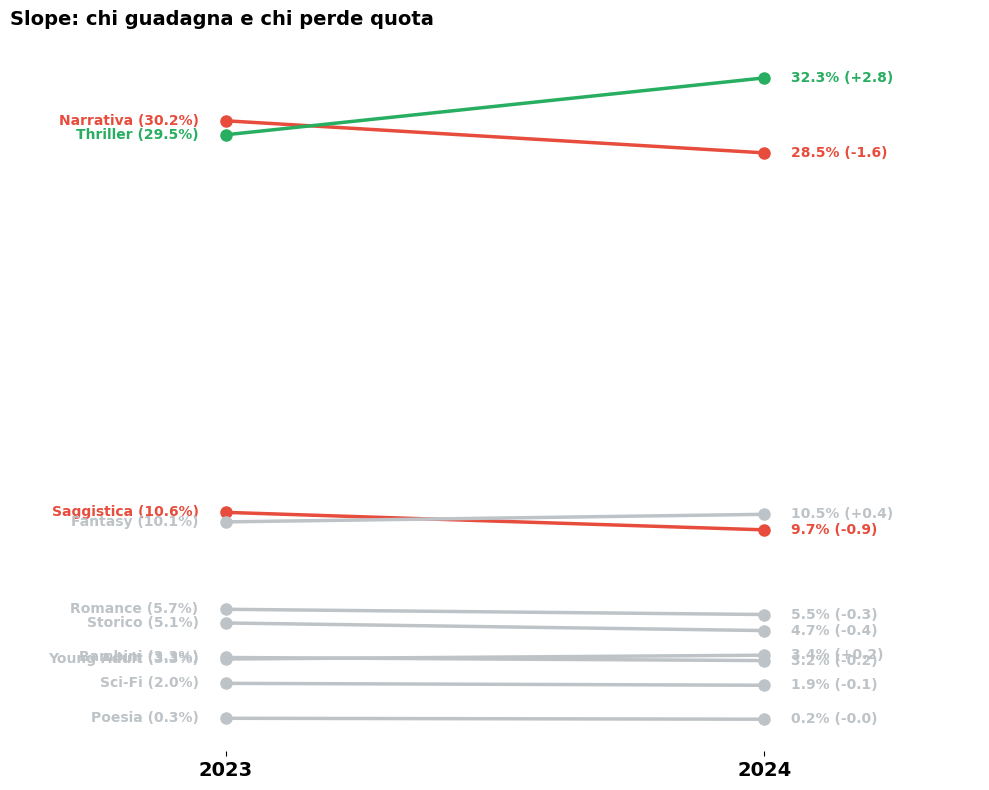

In [ ]:
# ============================================================
# 10.1 - SLOPE CHART: Quota 2023 vs 2024
# ============================================================
r23=df[df['anno']==2023].groupby('genere')['ricavo'].sum()
r24=df[df['anno']==2024].groupby('genere')['ricavo'].sum()
sh23=(r23/r23.sum()*100).sort_values(ascending=False); sh24=r24/r24.sum()*100
fig,ax=plt.subplots(figsize=(10,8))
for g in sh23.index:
    v1,v2=sh23[g],sh24[g]; d=v2-v1
    c='#27ae60' if d>0.5 else '#e74c3c' if d<-0.5 else '#bdc3c7'
    ax.plot([0,1],[v1,v2],'o-',color=c,linewidth=2.5,markersize=8)
    ax.text(-0.05,v1,f'{g} ({v1:.1f}%)',ha='right',va='center',fontsize=10,fontweight='bold',color=c)
    ax.text(1.05,v2,f'{v2:.1f}% ({d:+.1f})',ha='left',va='center',fontsize=10,fontweight='bold',color=c)
ax.set_xlim(-0.4,1.4);ax.set_xticks([0,1]);ax.set_xticklabels(['2023','2024'],fontsize=14,fontweight='bold')
ax.set_title('Slope: chi guadagna e chi perde quota',fontsize=14,fontweight='bold',loc='left',pad=15)
for sp in ['top','right','bottom','left']:ax.spines[sp].set_visible(False)
ax.yaxis.set_visible(False)
plt.tight_layout();plt.show()

## 10.2 Bump Chart: evoluzione del ranking
Questo è come uno slope chart, ma su $N$ periodi e con il ranking invece dei valori assoluti. Risponde alla domanda "chi sorpassa chi nel tempo?" in modo molto più leggibile di una tabella o di un line chart con valori assoluti. L'asse Y invertito (1 in cima) è contro-intuitivo da costruire ma naturale da leggere.

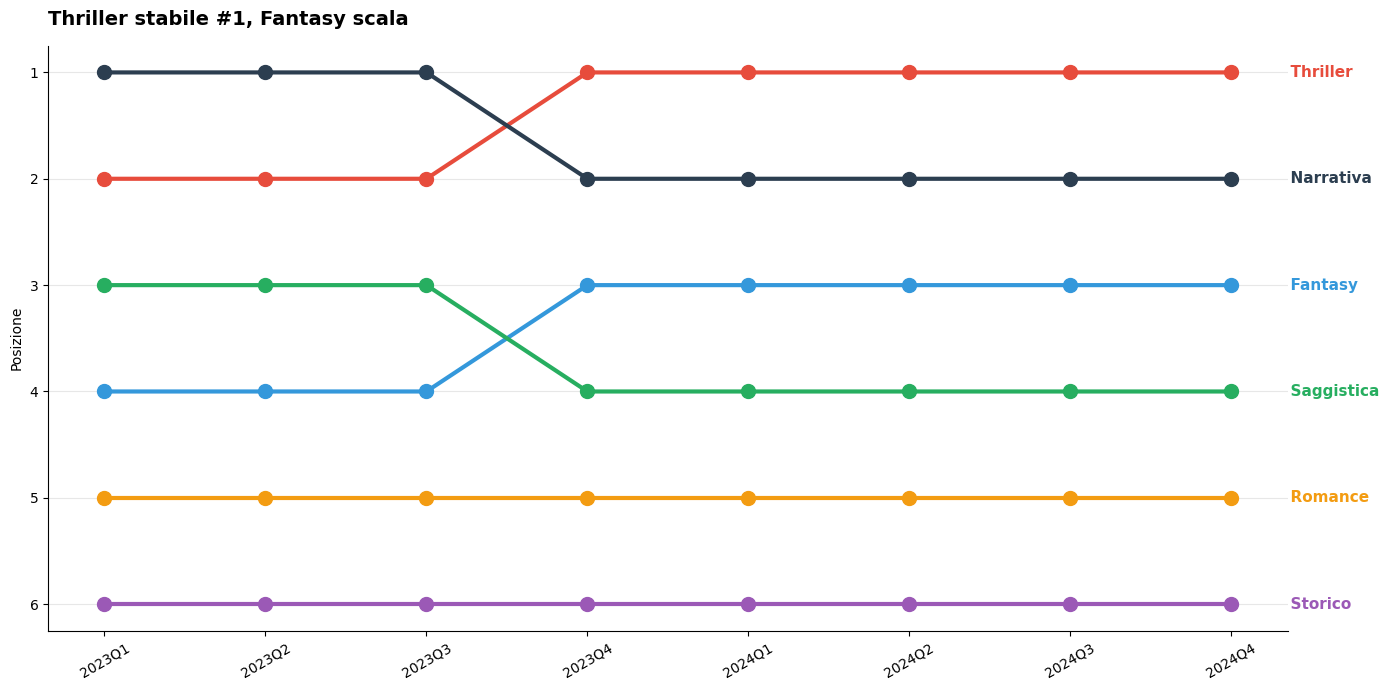

In [ ]:
# ============================================================
# 10.2 - BUMP CHART: Ranking per trimestre
# ============================================================
tr=df.groupby(['trimestre','genere'])['ricavo'].sum().reset_index()
tr['rank']=tr.groupby('trimestre')['ricavo'].rank(ascending=False,method='min')
top6=df.groupby('genere')['ricavo'].sum().nlargest(6).index
bd=tr[tr['genere'].isin(top6)]
fig,ax=plt.subplots(figsize=(14,7))
pal=dict(zip(top6,['#e74c3c','#2c3e50','#3498db','#27ae60','#f39c12','#9b59b6']))
trimestri=sorted(bd['trimestre'].unique())
for g in top6:
    gd=bd[bd['genere']==g].set_index('trimestre').reindex(trimestri)
    y=gd['rank'].values
    ax.plot(range(len(trimestri)),y,'o-',color=pal[g],linewidth=3,markersize=10,zorder=3)
    ax.text(len(trimestri)-0.7,y[-1],f'  {g}',va='center',fontsize=11,fontweight='bold',color=pal[g])
ax.set_xticks(range(len(trimestri)));ax.set_xticklabels(trimestri,fontsize=10,rotation=30)
ax.set_yticks(range(1,7));ax.set_ylabel('Posizione');ax.invert_yaxis()
ax.set_title('Thriller stabile #1, Fantasy scala',fontsize=14,fontweight='bold',loc='left',pad=15)
ax.grid(axis='y',alpha=0.3)
plt.tight_layout();plt.show()

## 10.4 Waterfall Chart: decomporre il cambiamento
Questo grafico scompone un cambiamento totale nelle sue componenti positive e negative. Risponde a "la crescita di 2M€ da dove viene?": non basta sapere il risultato finale, serve vedere quali generi hanno contribuito e quali hanno sottratto. È il grafico preferito dal management per le review di performance perché racconta una storia causale, non solo un risultato.

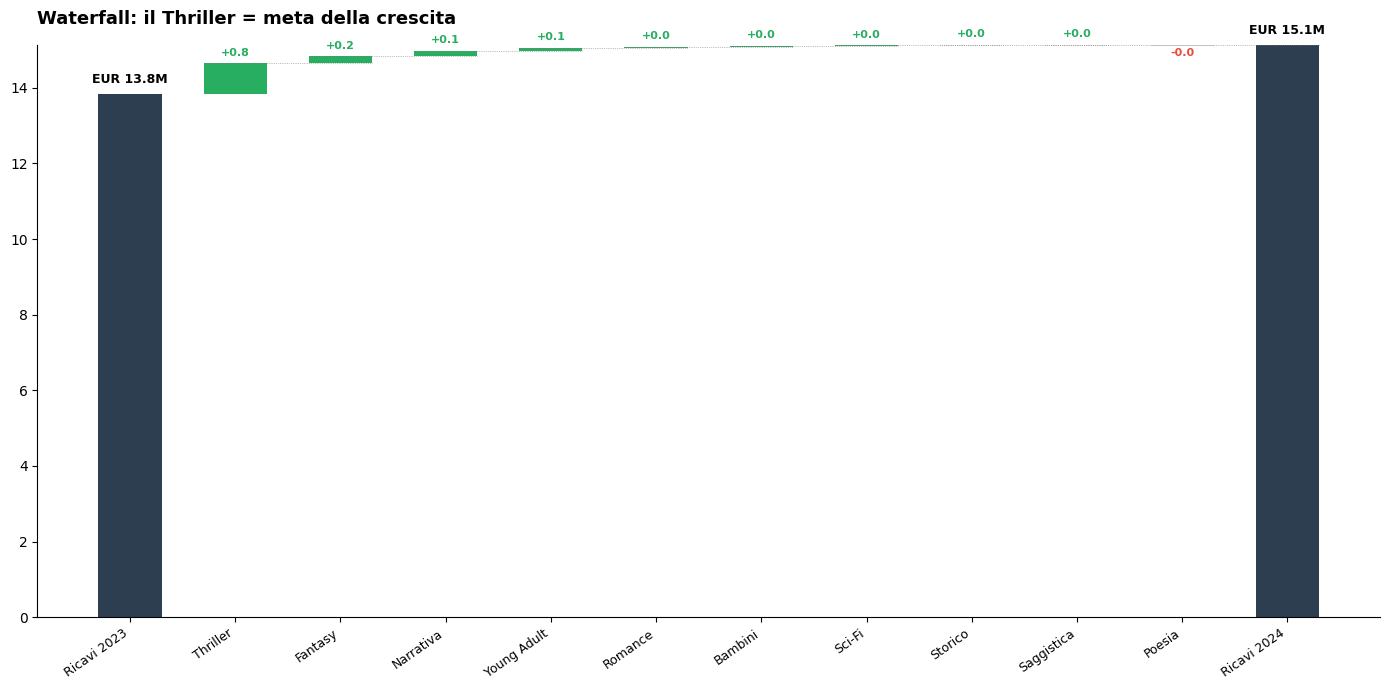

In [ ]:
# ============================================================
# 10.4 - WATERFALL: Da 2023 a 2024
# ============================================================
r23t=df[df['anno']==2023].groupby('genere')['ricavo'].sum()/1e6
r24t=df[df['anno']==2024].groupby('genere')['ricavo'].sum()/1e6
delta=(r24t-r23t).sort_values(ascending=False)
fig,ax=plt.subplots(figsize=(14,7))
start=r23t.sum()
labels=['Ricavi 2023'];vals=[start];cols=['#2c3e50']
for g,d in delta.items():
    labels.append(g);vals.append(d);cols.append('#27ae60' if d>=0 else '#e74c3c')
labels.append('Ricavi 2024');vals.append(r24t.sum());cols.append('#2c3e50')
running=0
for i,(lb,v) in enumerate(zip(labels,vals)):
    if i==0:
        ax.bar(i,v,color=cols[i],width=0.6);running=v
        ax.text(i,v+0.3,f'EUR {v:.1f}M',ha='center',fontsize=9,fontweight='bold')
    elif i==len(labels)-1:
        ax.bar(i,v,color=cols[i],width=0.6)
        ax.text(i,v+0.3,f'EUR {v:.1f}M',ha='center',fontsize=9,fontweight='bold')
    else:
        ax.bar(i,v,bottom=running,color=cols[i],width=0.6)
        lbl=f'+{v:.1f}' if v>=0 else f'{v:.1f}'
        yt=running+v+0.2 if v>=0 else running+v-0.3
        ax.text(i,yt,lbl,ha='center',fontsize=8,color=cols[i],fontweight='bold')
        running+=v
        if i<len(labels)-1:ax.plot([i-0.3,i+1.3],[running,running],color='gray',linewidth=0.5,linestyle=':')
ax.set_xticks(range(len(labels)));ax.set_xticklabels(labels,fontsize=9,rotation=35,ha='right')
ax.set_title('Waterfall: il Thriller = meta della crescita',fontsize=13,fontweight='bold',loc='left',pad=15)
plt.tight_layout();plt.show()

## 10.5 Waffle Chart: un altro dolce per le composizioni

Nasce come alternativa al pie chart per mostrare composizioni. Una griglia 10×10 dove ogni cella vale l'1% del totale. Meno preciso di uno stacked bar 100%, ma molto più intuitivo per audience non tecnica: "30 celle su 100 sono Thriller" è immediatamente comprensibile anche senza leggere le etichette.

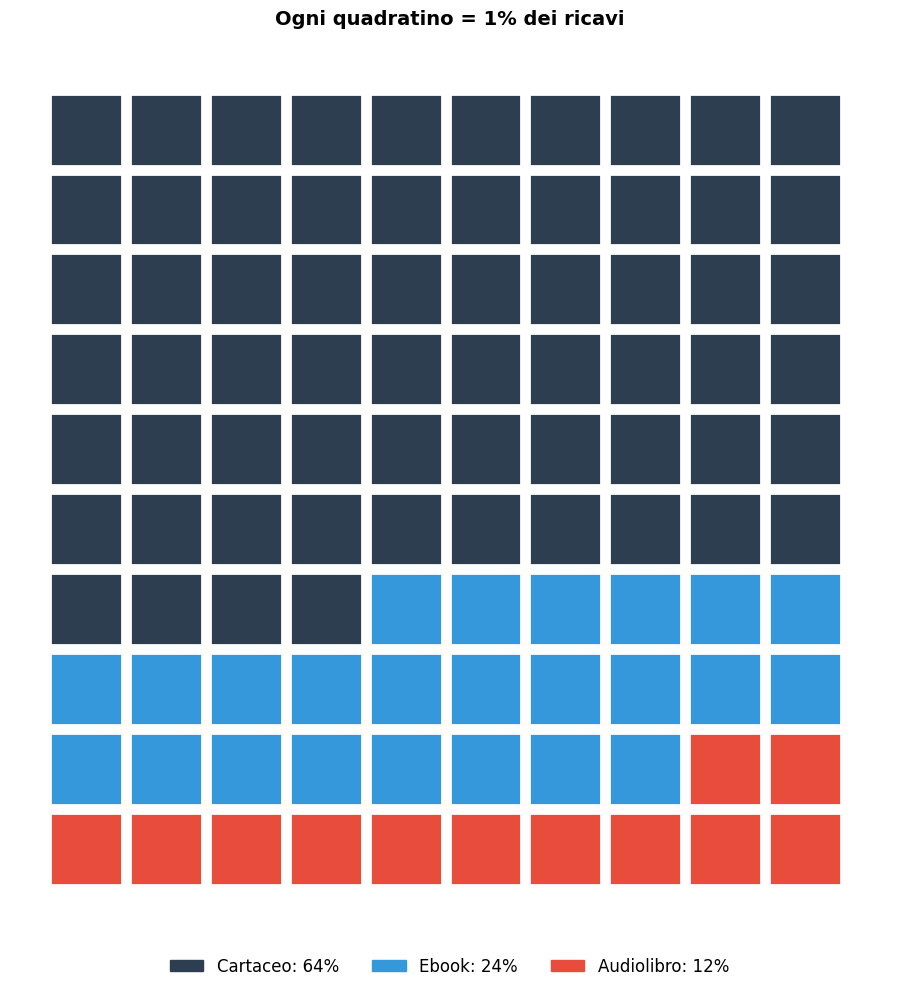

In [ ]:
# ============================================================
# 10.5 - WAFFLE CHART
# ============================================================
fsh=df.groupby('formato')['ricavo'].sum()
fp=(fsh/fsh.sum()*100).round().astype(int)
fp.iloc[fp.values.argmax()]+=(100-fp.sum())
fig,ax=plt.subplots(figsize=(10,10))
cw={'Cartaceo':'#2c3e50','Ebook':'#3498db','Audiolibro':'#e74c3c'}
grid=[]
for fmt in ['Cartaceo','Ebook','Audiolibro']:grid.extend([cw[fmt]]*fp[fmt])
for i in range(100):
    r,c=divmod(i,10)
    ax.add_patch(plt.Rectangle((c,9-r),0.9,0.9,facecolor=grid[i],edgecolor='white',linewidth=2))
ax.set_xlim(-0.5,10.5);ax.set_ylim(-0.5,10.5);ax.set_aspect('equal');ax.axis('off')
li=[mpatches.Patch(color=cw[f],label=f'{f}: {fp[f]}%') for f in ['Cartaceo','Ebook','Audiolibro']]
ax.legend(handles=li,loc='upper center',bbox_to_anchor=(0.5,-0.02),ncol=3,fontsize=12,frameon=False)
ax.set_title('Ogni quadratino = 1% dei ricavi',fontsize=14,fontweight='bold',pad=15)
plt.tight_layout();plt.show()

---
# Parte 11 — Dashboard Design

Un dashboard non è una raccolta di grafici. È una storia visiva strutturata, e come tale segue la stessa logica del Pyramid Principle: il messaggio principale in cima, gli argomenti di supporto al centro, le evidenze di dettaglio in basso.

La struttura a tre livelli non è una convenzione estetica, deve essere funzionale.

Le KPI card in alto rispondono alla domanda che ogni dirigente ha in testa prima ancora di aprire il report: "stiamo andando bene o male?". I grafici nella riga centrale spiegano perché. La riga in basso fornisce il dettaglio per chi vuole verificare.

**Principi:**
1. KPI in alto — numeri chiave
2. Grafici supporto al centro
3. Dettaglio in basso

**Regole:**
- **Max 6-8 grafici**: Oltre quella soglia il cervello smette di leggere e inizia a scansionare. Se hai più messaggi da comunicare, hai bisogno di più dashboard, non di una più grande.
- **Palette coerente su tutto il dashboard**. Se Thriller è rosso nel bar chart, deve essere rosso anche nel line chart e nell'heatmap. Usare colori diversi per la stessa categoria su grafici diversi costringe il lettore a ricostruire mentalmente le corrispondenze. Un lavoro che non dovrebbe fare lui!!
- **Un solo messaggio per dashboard**. Il titolo generale del dashboard deve essere un "So What?" esattamente come i titoli dei singoli grafici. "DASHBOARD EDITORIALE — Q4 2024" è un titolo descrittivo. "Il catalogo cresce (+15% YoY) ma con rischi di concentrazione e stagionalità" è un titolo che racconta qualcosa.

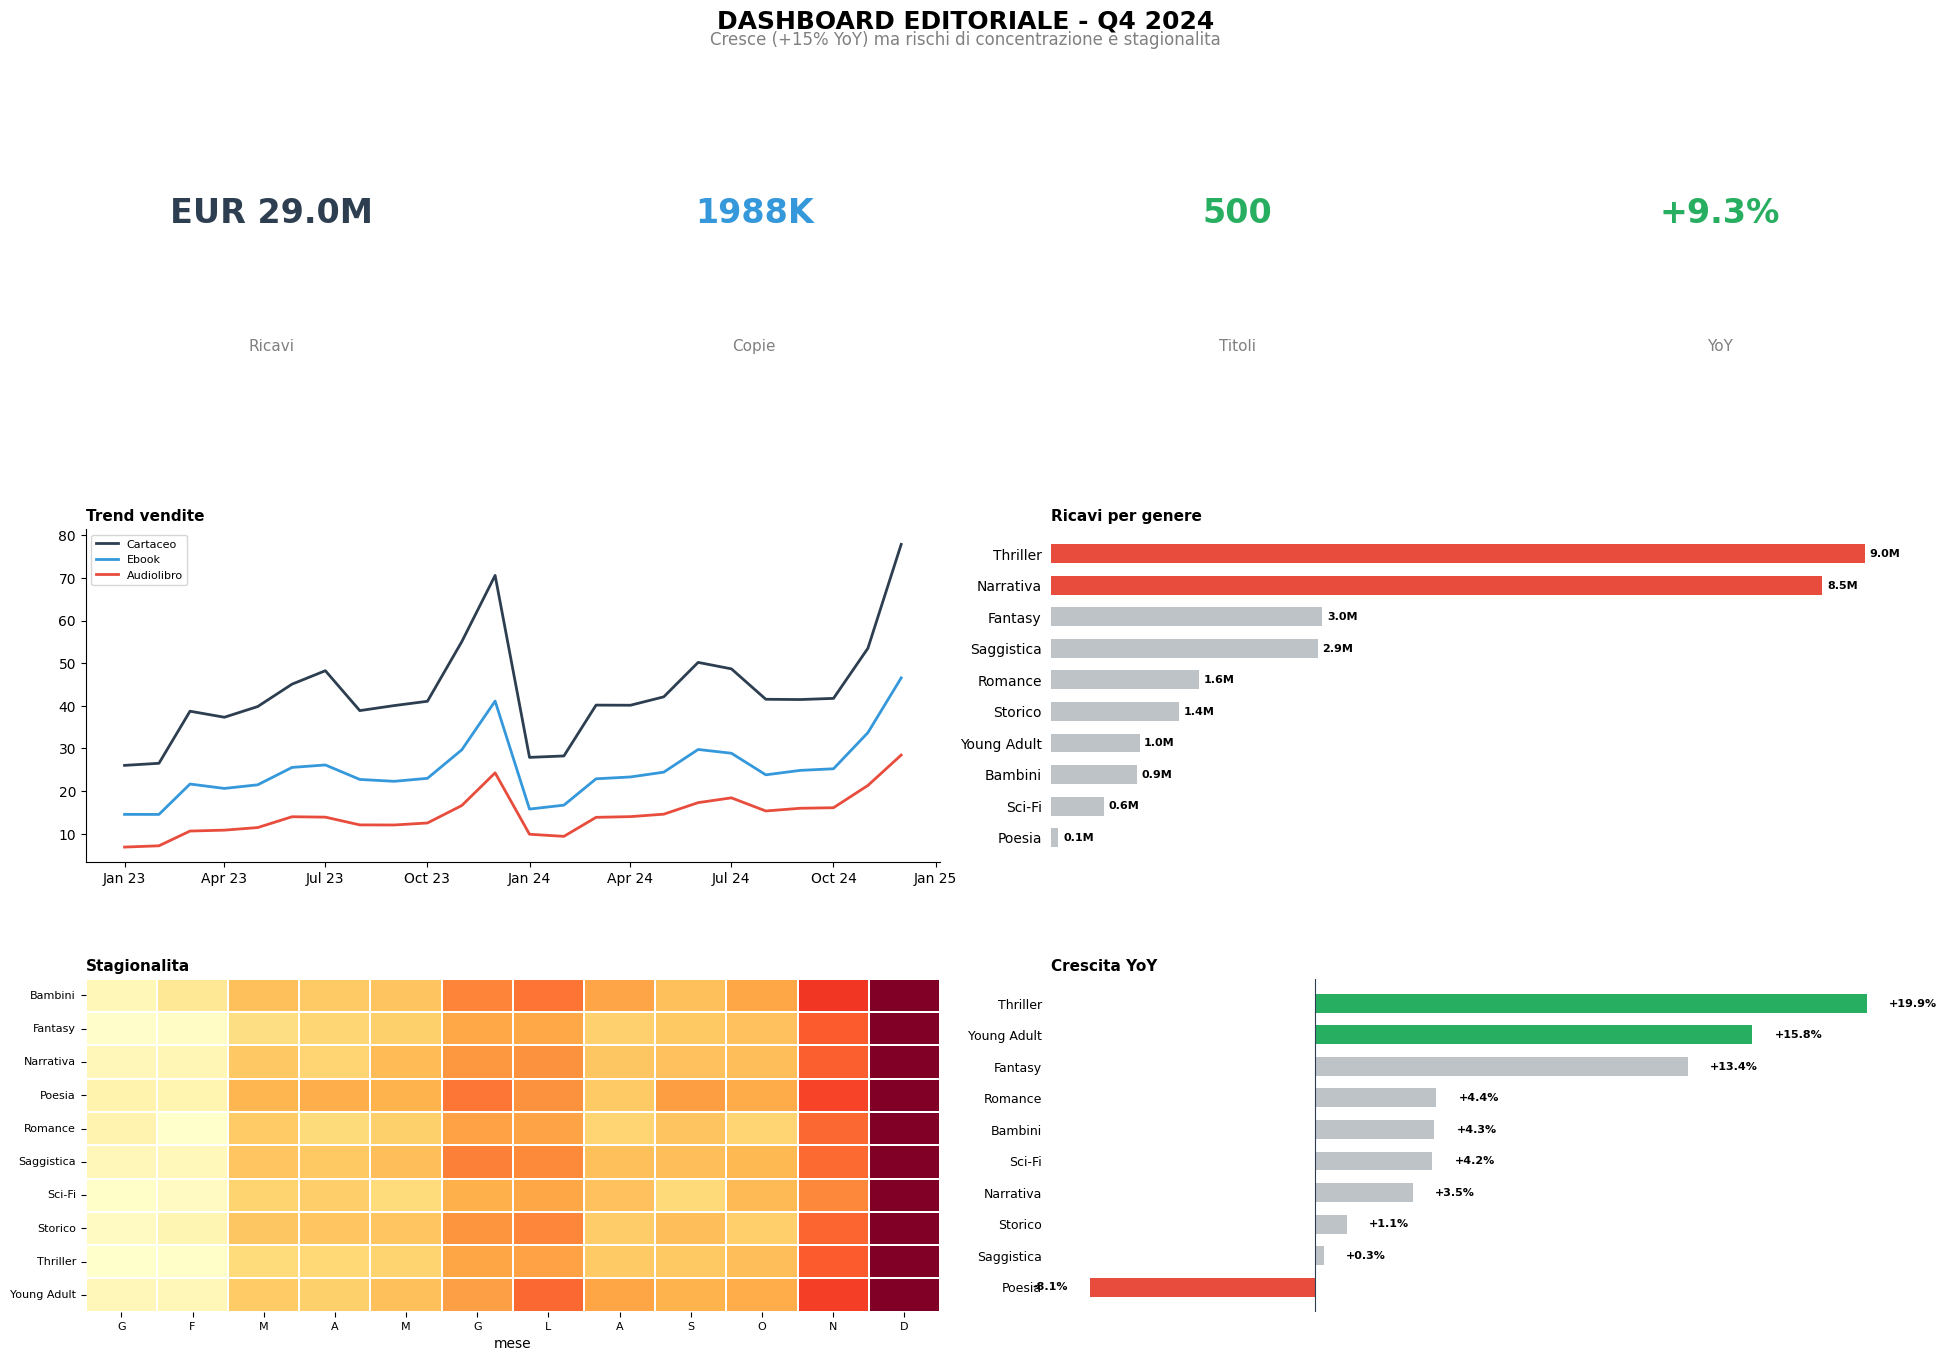

In [ ]:
# ============================================================
# 11 - EXECUTIVE DASHBOARD
# ============================================================
fig=plt.figure(figsize=(20,14))
fig.suptitle('DASHBOARD EDITORIALE - Q4 2024',fontsize=18,fontweight='bold',y=0.98)
fig.text(0.5,0.955,'Cresce (+15% YoY) ma rischi di concentrazione e stagionalita',fontsize=12,color='gray',ha='center')
gs=fig.add_gridspec(3,4,hspace=0.35,wspace=0.3,top=0.93,bottom=0.05,left=0.06,right=0.97)
# KPI
rt=df['ricavo'].sum()/1e6;ct=df['copie_vendute'].sum()/1000;nt=df['libro_id'].nunique()
r23x=df[df['anno']==2023]['ricavo'].sum();r24x=df[df['anno']==2024]['ricavo'].sum();yt=(r24x-r23x)/r23x*100
for i,(v,l,c) in enumerate([(f'EUR {rt:.1f}M','Ricavi','#2c3e50'),(f'{ct:.0f}K','Copie','#3498db'),(f'{nt}','Titoli','#27ae60'),(f'{yt:+.1f}%','YoY','#27ae60' if yt>0 else '#e74c3c')]):
    ax=fig.add_subplot(gs[0,i]);ax.text(0.5,0.6,v,ha='center',va='center',fontsize=24,fontweight='bold',color=c)
    ax.text(0.5,0.2,l,ha='center',va='center',fontsize=11,color='gray');ax.set_xlim(0,1);ax.set_ylim(0,1);ax.axis('off')
# Trend
axt=fig.add_subplot(gs[1,:2])
for fmt,c in [('Cartaceo','#2c3e50'),('Ebook','#3498db'),('Audiolibro','#e74c3c')]:
    s=df[df['formato']==fmt].groupby('data')['copie_vendute'].sum()/1000
    axt.plot(s.index,s.values,label=fmt,color=c,linewidth=2)
axt.set_title('Trend vendite',fontsize=11,fontweight='bold',loc='left');axt.legend(fontsize=8)
axt.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
# Bar
axb=fig.add_subplot(gs[1,2:])
rg=df.groupby('genere')['ricavo'].sum().sort_values(ascending=True)/1e6
cb=['#e74c3c' if g in rg.nlargest(2).index else '#bdc3c7' for g in rg.index]
axb.barh(rg.index,rg.values,color=cb,height=0.6)
for i,(g,v) in enumerate(rg.items()):axb.text(v+0.05,i,f'{v:.1f}M',va='center',fontsize=8,fontweight='bold')
axb.set_title('Ricavi per genere',fontsize=11,fontweight='bold',loc='left')
axb.xaxis.set_visible(False)
for sp in ['bottom','left']:axb.spines[sp].set_visible(False)
axb.tick_params(left=False)
# Heatmap
axh=fig.add_subplot(gs[2,:2])
hd=df.groupby([df['data'].dt.month,'genere'])['copie_vendute'].sum().reset_index()
hd.columns=['mese','genere','copie']
ph=hd.pivot(index='genere',columns='mese',values='copie')
pn=ph.div(ph.max(axis=1),axis=0)
sns.heatmap(pn,cmap='YlOrRd',xticklabels=['G','F','M','A','M','G','L','A','S','O','N','D'],ax=axh,cbar=False,linewidths=0.3)
axh.set_title('Stagionalita',fontsize=11,fontweight='bold',loc='left');axh.set_ylabel('');axh.tick_params(labelsize=8)
# YoY
axy=fig.add_subplot(gs[2,2:])
r23g=df[df['anno']==2023].groupby('genere')['ricavo'].sum()
r24g=df[df['anno']==2024].groupby('genere')['ricavo'].sum()
yg=((r24g-r23g)/r23g*100).sort_values()
cyy=['#e74c3c' if v<0 else '#bdc3c7' if v<15 else '#27ae60' for v in yg.values]
axy.barh(yg.index,yg.values,color=cyy,height=0.6);axy.axvline(0,color='#2c3e50',linewidth=0.8)
for bar,val in zip(axy.patches,yg.values):
    axy.text(val+(0.8 if val>=0 else -0.8),bar.get_y()+bar.get_height()/2,f'{val:+.1f}%',va='center',ha='left' if val>=0 else 'right',fontsize=8,fontweight='bold')
axy.set_title('Crescita YoY',fontsize=11,fontweight='bold',loc='left')
for sp in ['top','right','bottom','left']:axy.spines[sp].set_visible(False)
axy.xaxis.set_visible(False);axy.tick_params(left=False,labelsize=9)
plt.show()

---
# Parte 12 — Esercizio Finale: Brief → Presentazione

## Il Brief

> *Il board vuole capire se ha senso investire nell'audiolibro. 4 slide, dati alla mano.*

## La Piramide

```
MESSAGGIO: Audiolibro = crescita piu alta. Triplicare investimento.

+-- SLIDE 1: Il digitale cresce (stacked area %)
+-- SLIDE 2: Audiolibro cresce 3x (indice base 100)
+-- SLIDE 3: Dove investire (scatter penetrazione vs mercato)
+-- SLIDE 4: Piano d'azione (tabella + proiezione)
```

In [ ]:
# ============================================================
# 12 - Analisi
# ============================================================
print('='*60+'\nANALISI AUDIOLIBRO\n'+'='*60)
for fmt in FORMATI:
    r23f=df[(df['anno']==2023)&(df['formato']==fmt)]['ricavo'].sum()
    r24f=df[(df['anno']==2024)&(df['formato']==fmt)]['ricavo'].sum()
    print(f'\n{fmt}: EUR {r23f/1e6:.2f}M -> EUR {r24f/1e6:.2f}M ({(r24f-r23f)/r23f*100:+.1f}%)')
print('\nPenetrazione audio per genere (2024):')
a24=df[(df['anno']==2024)&(df['formato']=='Audiolibro')].groupby('genere')['ricavo'].sum()
t24=df[df['anno']==2024].groupby('genere')['ricavo'].sum()
for g,v in (a24/t24*100).sort_values(ascending=False).items():print(f'  {g}: {v:.1f}%')

ANALISI AUDIOLIBRO

Cartaceo: EUR 9.06M -> EUR 9.55M (+5.4%)

Ebook: EUR 3.28M -> EUR 3.67M (+11.8%)

Audiolibro: EUR 1.50M -> EUR 1.91M (+27.8%)

Penetrazione audio per genere (2024):
  Young Adult: 13.0%
  Bambini: 13.0%
  Narrativa: 12.9%
  Saggistica: 12.6%
  Fantasy: 12.5%
  Thriller: 12.5%
  Romance: 12.4%
  Storico: 12.3%
  Sci-Fi: 12.2%
  Poesia: 11.6%


### Le 4 Slide

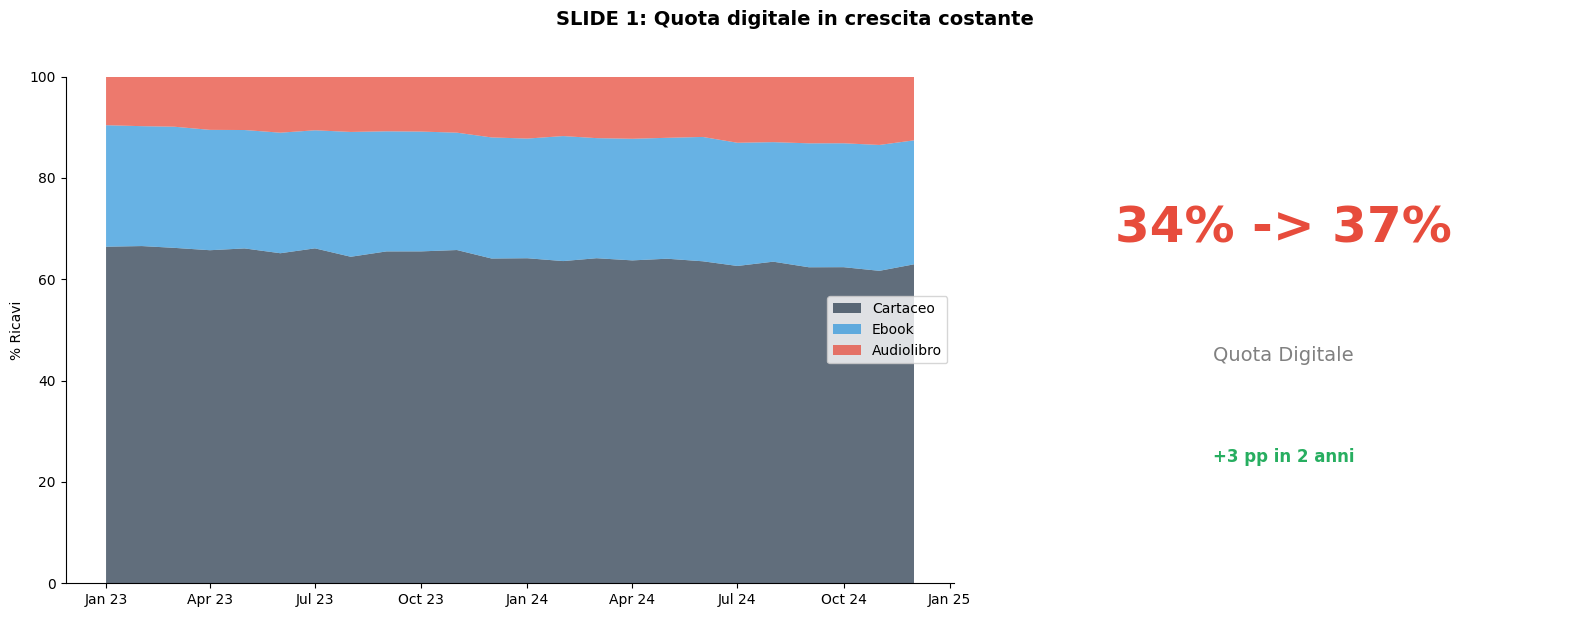

In [ ]:
# ============================================================
# SLIDE 1: Il mercato cambia
# ============================================================
fm=(df.groupby([df['data'],'formato'])['ricavo'].sum().reset_index()
    .pivot(index='data',columns='formato',values='ricavo').fillna(0))
fmp=fm.div(fm.sum(axis=1),axis=0)*100
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6),gridspec_kw={'width_ratios':[1.5,1]})
ax1.stackplot(fmp.index,[fmp['Cartaceo'],fmp['Ebook'],fmp['Audiolibro']],
    labels=['Cartaceo','Ebook','Audiolibro'],colors=['#2c3e50','#3498db','#e74c3c'],alpha=0.75)
ax1.set_ylim(0,100);ax1.set_ylabel('% Ricavi');ax1.legend(loc='center right')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ds=100-fmp.iloc[0]['Cartaceo'];de=100-fmp.iloc[-1]['Cartaceo']
ax2.text(0.5,0.7,f'{ds:.0f}% -> {de:.0f}%',ha='center',va='center',fontsize=36,fontweight='bold',color='#e74c3c')
ax2.text(0.5,0.45,'Quota Digitale',ha='center',va='center',fontsize=14,color='gray')
ax2.text(0.5,0.25,f'+{de-ds:.0f} pp in 2 anni',ha='center',va='center',fontsize=12,color='#27ae60',fontweight='bold')
ax2.set_xlim(0,1);ax2.set_ylim(0,1);ax2.axis('off')
plt.suptitle('SLIDE 1: Quota digitale in crescita costante',fontsize=14,fontweight='bold',y=1.02)
plt.tight_layout();plt.show()

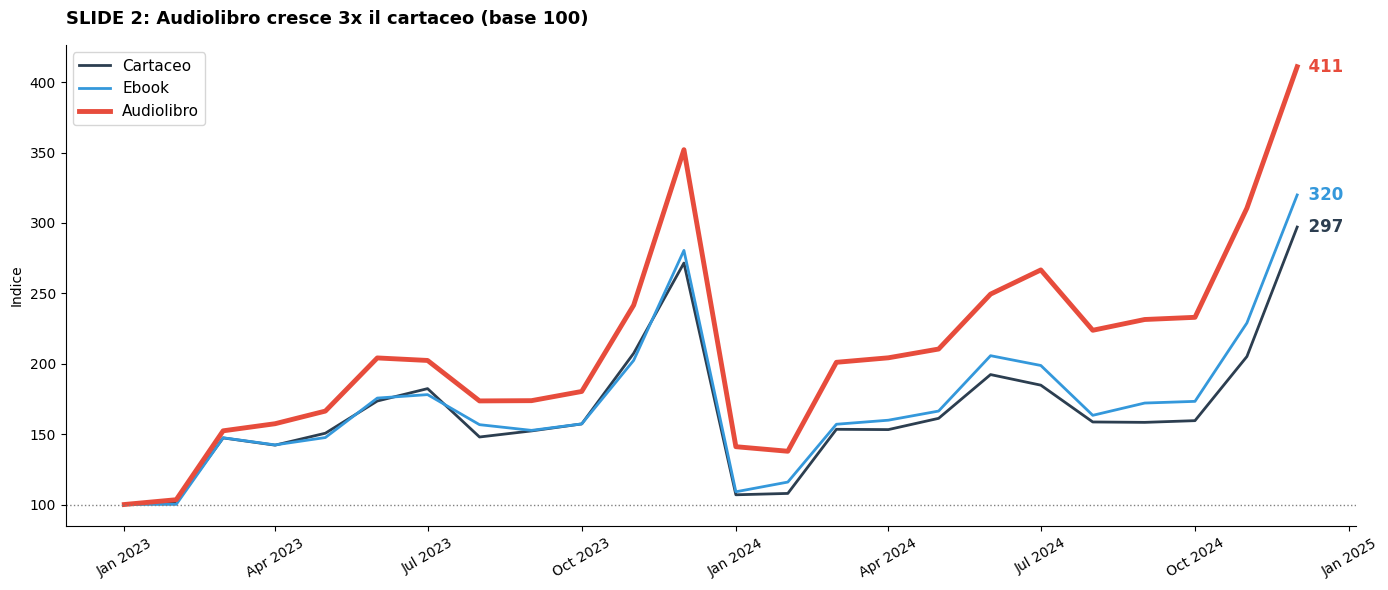

In [ ]:
# ============================================================
# SLIDE 2: Audiolibro cresce 3x
# ============================================================
fig,ax=plt.subplots(figsize=(14,6))
fc={'Cartaceo':'#2c3e50','Ebook':'#3498db','Audiolibro':'#e74c3c'}
for fmt,c in fc.items():
    s=df[df['formato']==fmt].groupby('data')['ricavo'].sum()
    idx=s/s.iloc[0]*100
    ax.plot(idx.index,idx.values,color=c,linewidth=3.5 if fmt=='Audiolibro' else 2,label=fmt)
    ax.text(idx.index[-1],idx.values[-1],f'  {idx.values[-1]:.0f}',va='center',fontsize=12,fontweight='bold',color=c)
ax.axhline(100,color='gray',linestyle=':',linewidth=1)
ax.set_title('SLIDE 2: Audiolibro cresce 3x il cartaceo (base 100)',fontsize=13,fontweight='bold',loc='left',pad=15)
ax.set_ylabel('Indice');ax.legend(fontsize=11,loc='upper left')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'));plt.xticks(rotation=30)
plt.tight_layout();plt.show()

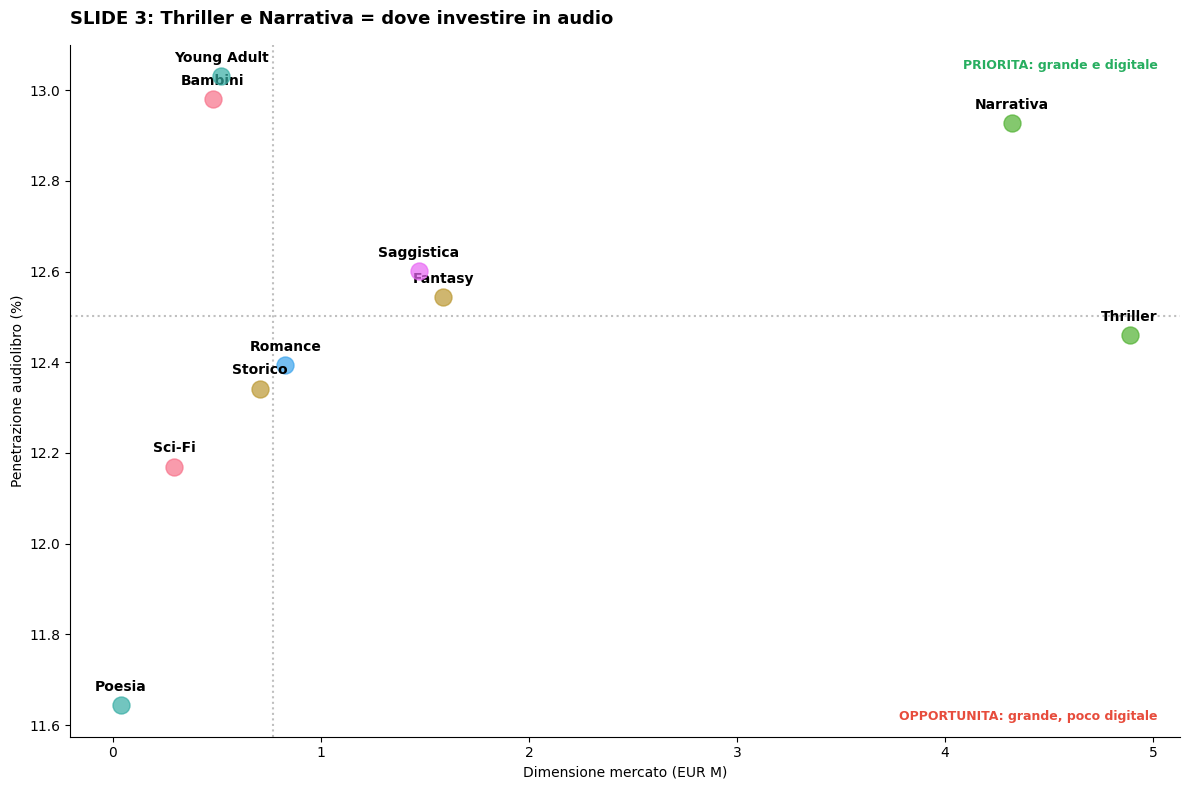

In [ ]:
# ============================================================
# SLIDE 3: Dove investire
# ============================================================
a24g=df[(df['anno']==2024)&(df['formato']=='Audiolibro')].groupby('genere')['ricavo'].sum()
t24g=df[df['anno']==2024].groupby('genere')['ricavo'].sum()
ap=a24g/t24g*100;tg=t24g/1e6
sdf=pd.DataFrame({'mercato':tg,'audio_pen':ap}).dropna()
fig,ax=plt.subplots(figsize=(12,8))
ax.axhline(sdf['audio_pen'].median(),color='gray',linestyle=':',alpha=0.5)
ax.axvline(sdf['mercato'].median(),color='gray',linestyle=':',alpha=0.5)
for g in sdf.index:
    ax.scatter(sdf.loc[g,'mercato'],sdf.loc[g,'audio_pen'],s=150,alpha=0.7,zorder=3)
    ax.annotate(g,(sdf.loc[g,'mercato'],sdf.loc[g,'audio_pen']),fontsize=10,fontweight='bold',ha='center',va='bottom',xytext=(0,8),textcoords='offset points')
ax.text(0.98,0.98,'PRIORITA: grande e digitale',transform=ax.transAxes,fontsize=9,va='top',ha='right',color='#27ae60',fontweight='bold')
ax.text(0.98,0.02,'OPPORTUNITA: grande, poco digitale',transform=ax.transAxes,fontsize=9,va='bottom',ha='right',color='#e74c3c',fontweight='bold')
ax.set_xlabel('Dimensione mercato (EUR M)');ax.set_ylabel('Penetrazione audiolibro (%)')
ax.set_title('SLIDE 3: Thriller e Narrativa = dove investire in audio',fontsize=13,fontweight='bold',loc='left',pad=15)
plt.tight_layout();plt.show()

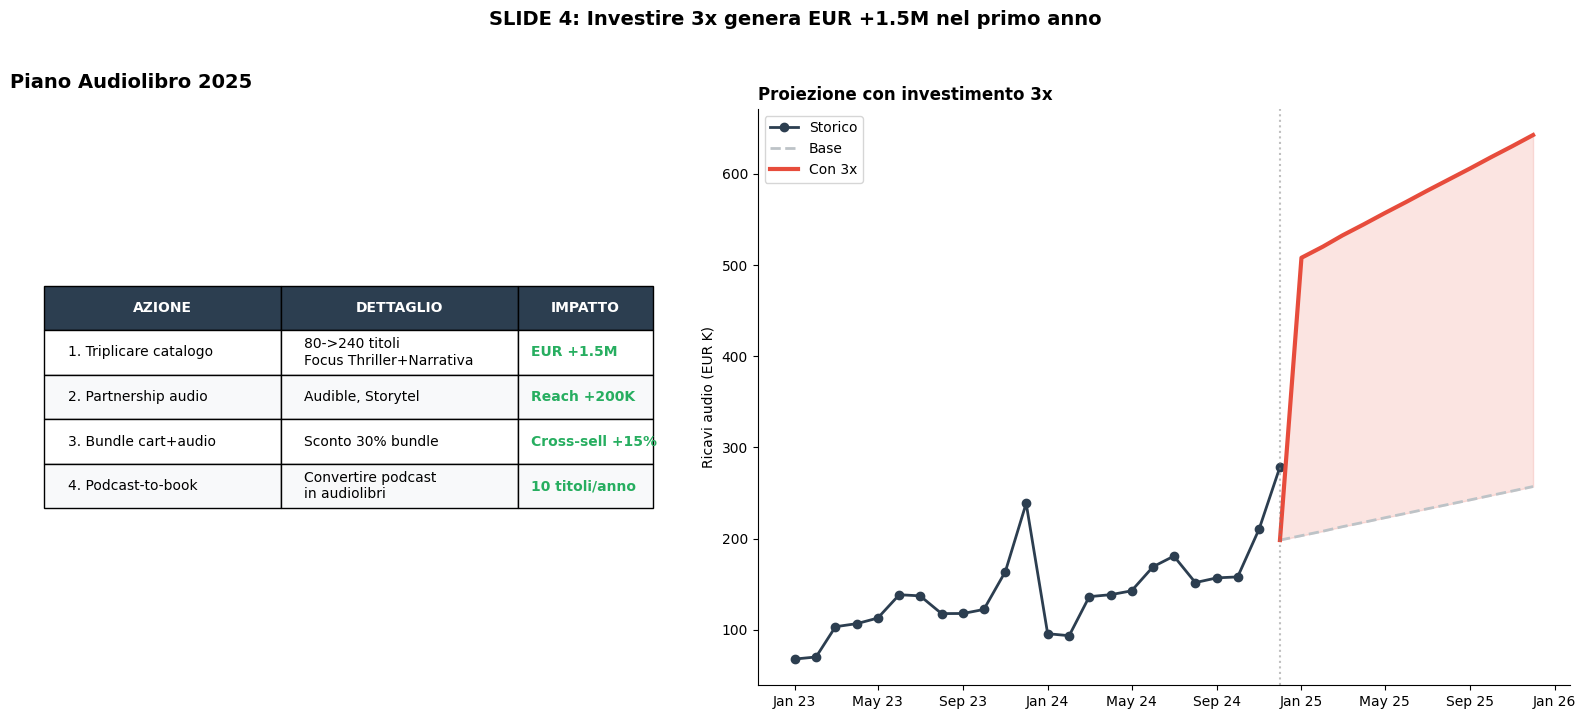

In [ ]:
# ============================================================
# SLIDE 4: Raccomandazione e proiezione
# ============================================================
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,7),gridspec_kw={'width_ratios':[1,1.2]})
ax1.axis('off')
ax1.set_title('Piano Audiolibro 2025',fontsize=14,fontweight='bold',loc='left',pad=15)
actions=[['AZIONE','DETTAGLIO','IMPATTO'],
    ['1. Triplicare catalogo','80->240 titoli\nFocus Thriller+Narrativa','EUR +1.5M'],
    ['2. Partnership audio','Audible, Storytel','Reach +200K'],
    ['3. Bundle cart+audio','Sconto 30% bundle','Cross-sell +15%'],
    ['4. Podcast-to-book','Convertire podcast\nin audiolibri','10 titoli/anno']]
table=ax1.table(cellText=actions[1:],colLabels=actions[0],cellLoc='left',loc='center',colWidths=[0.35,0.35,0.20])
table.auto_set_font_size(False);table.set_fontsize(10);table.scale(1,2.5)
for j in range(3):table[0,j].set_facecolor('#2c3e50');table[0,j].set_text_props(color='white',fontweight='bold')
for i in range(1,5):
    for j in range(3):table[i,j].set_facecolor('#f8f9fa' if i%2==0 else 'white')
    table[i,2].set_text_props(color='#27ae60',fontweight='bold')
# Proiezione
ax2.set_title('Proiezione con investimento 3x',fontsize=12,fontweight='bold',loc='left')
mesi=pd.date_range('2023-01-01',periods=36,freq='MS')
astorico=df[df['formato']=='Audiolibro'].groupby('data')['ricavo'].sum()/1000
z=np.polyfit(np.arange(len(astorico)),astorico.values,1)
proj=np.polyval(z,np.arange(36));proj3x=proj.copy();proj3x[24:]*=2.5
ax2.plot(mesi[:24],astorico.values,'o-',color='#2c3e50',linewidth=2,label='Storico')
ax2.plot(mesi[23:],proj[23:],'--',color='#bdc3c7',linewidth=2,label='Base')
ax2.plot(mesi[23:],proj3x[23:],'-',color='#e74c3c',linewidth=3,label='Con 3x')
ax2.fill_between(mesi[23:],proj[23:],proj3x[23:],alpha=0.15,color='#e74c3c')
ax2.axvline(mesi[23],color='gray',linestyle=':',alpha=0.5)
ax2.set_ylabel('Ricavi audio (EUR K)');ax2.legend(fontsize=10,loc='upper left')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.suptitle('SLIDE 4: Investire 3x genera EUR +1.5M nel primo anno',fontsize=14,fontweight='bold',y=1.02)
plt.tight_layout();plt.show()

---
# Recap finale

## Parte 1: Le basi

| Concetto | In una frase |
|----------|-------------|
| Pyramid Principle | Parti dalla conclusione, non dai dati |
| So What? | Ogni grafico: osservazione → insight → azione |
| Data-Ink Ratio | Meno decorazione, piu dati |
| Visual Encoding | Posizione e lunghezza > Area e colore |

## Parte 2: La pratica

| Concetto | In una frase |
|----------|-------------|
| Matrice decisionale | Scegli il grafico dall'obiettivo, non dal dato |
| Trasformazioni | Normalizza, indicizza, smooth prima di visualizzare |
| Grafici avanzati | Slope, Bump, Dumbbell, Waterfall, Waffle per casi specifici |
| Dashboard | KPI in alto, supporto al centro, dettaglio in basso |
| Brief → Presentazione | Piramide prima, dati poi, grafici alla fine |

## La regola d'oro

> **Non chiedete "che grafico faccio?". Chiedete "cosa devo comunicare?".**

## Risorse

- **The Pyramid Principle** — Barbara Minto
- **Storytelling with Data** — Cole Nussbaumer Knaflic
- **The Visual Display of Quantitative Information** — Edward Tufte
- **Fundamentals of Data Visualization** — Claus Wilke (gratis online)

---

*"The greatest value of a picture is when it forces us to notice what we never expected to see."* — John Tukey